In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, RNN

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn import preprocessing
from sklearn.cluster import KMeans  
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2  
from sklearn.ensemble import ExtraTreesClassifier 
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

In [33]:
#EXPLORATORYY DATA ANALYSIS AND VISUALIZATION(Drop NaN values)
gunviolence = pd.read_csv("/content/gun-violence-data_01-2013_03-2018.csv") #("gun_violence_2017_2018_parsed.csv")
#reduce data to only features we wish to classify
gunviolence = gunviolence.filter(['incident_id', 'date', 'state', 'city_or_county', 'n_killed', 'n_injured', 'n_victim'],axis=1)   # , 'n_guns_involved'

# Drop NaN values
#gunviolence = gunviolence.dropna()

# Replace NaN values with 0
gunviolence.fillna(0, inplace=True)

#Convert to date time data type
gunviolence["newDate"] = pd.to_datetime(gunviolence['date']) 

# Convert the "date" column to a numerical representation
gunviolence["date"] = (pd.to_datetime(gunviolence["date"]) - pd.to_datetime("2012-01-01")).dt.days

#Get Month and Year Data
gunviolence['year'] = gunviolence.newDate.dt.year
gunviolence['month'] = gunviolence.newDate.dt.month

# Create a new column for the number of victims
gunviolence['victims'] = gunviolence['n_killed'] + gunviolence['n_injured']
gunviolence["n_victim"] = gunviolence['victims']

gunviolence = gunviolence.drop(['n_killed', 'n_injured'],axis=1)

# Calculate the mean of the 'n_victim' column
mean_n_victim = gunviolence['n_victim'].mean()

# Print the mean
print(mean_n_victim)

# Create class labels for visualization
gunviolence["severity"] = pd.cut(gunviolence["n_victim"], bins=[-1, 1, 3, float("inf")], labels=["Low Severity", "Moderate Severity", "High Severity"])

gunviolence.head()


0.7462960567764116


,incident_id,date,state,city_or_county,newDate,year,month,victims,n_victim,severity
0,461105,366,Pennsylvania,Mckeesport,2013-01-01,2013,1,4,4,High Severity
1,460726,366,California,Hawthorne,2013-01-01,2013,1,4,4,High Severity
2,478855,366,Ohio,Lorain,2013-01-01,2013,1,4,4,High Severity
3,478925,370,Colorado,Aurora,2013-01-05,2013,1,4,4,High Severity
4,478959,372,North Carolina,Greensboro,2013-01-07,2013,1,4,4,High Severity


In [3]:
gunviolence.columns

Index(['incident_id', 'date', 'state', 'city_or_county', 'newDate', 'year',
       'month', 'victims', 'n_victim', 'severity'],
      dtype='object')

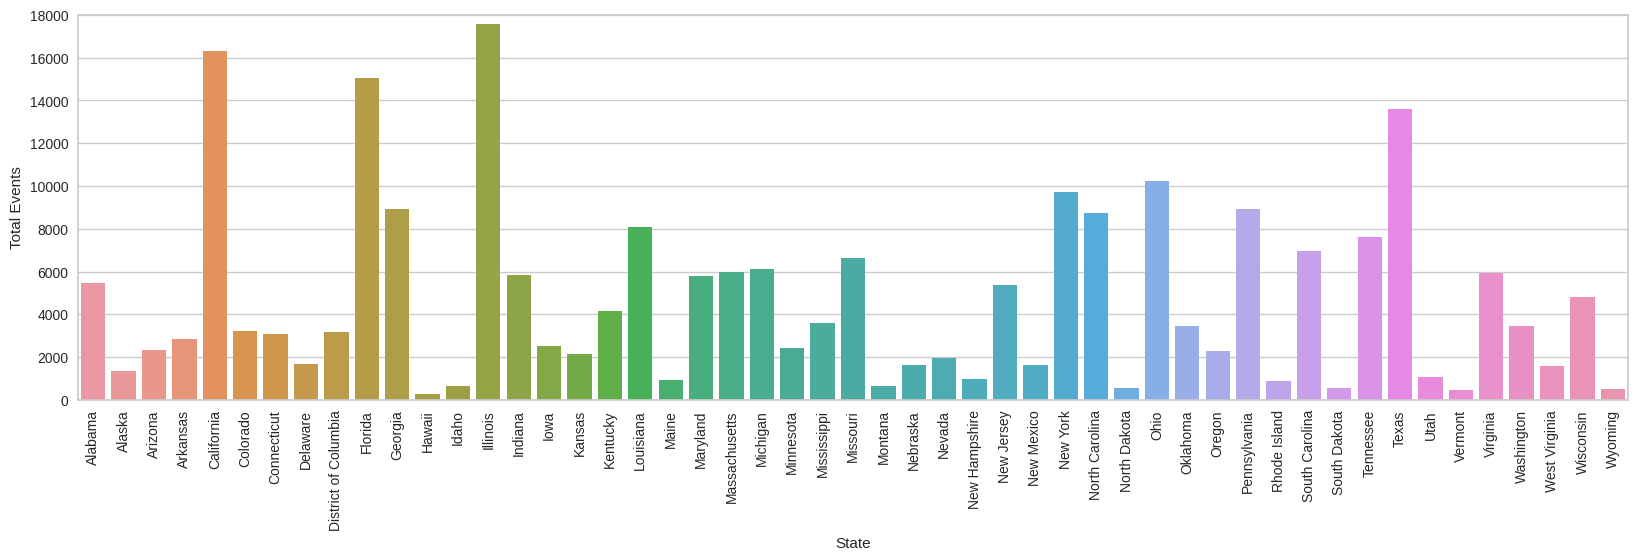

In [4]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x="state", data=gunviolence.sort_values(by=['state']))
plt.xticks(x = gunviolence['state'],  rotation='vertical')
plt.ylim(ymax = 18000, ymin = 0)

plt.xlabel('State') 
plt.ylabel('Total Events') 
plt.show() 

<ipython-input-5-0942df147e35>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  states = (gvDf.groupby(['state']).sum()).index
<ipython-input-5-0942df147e35>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sDF = (gvDf.groupby(['state']).sum())['victims']


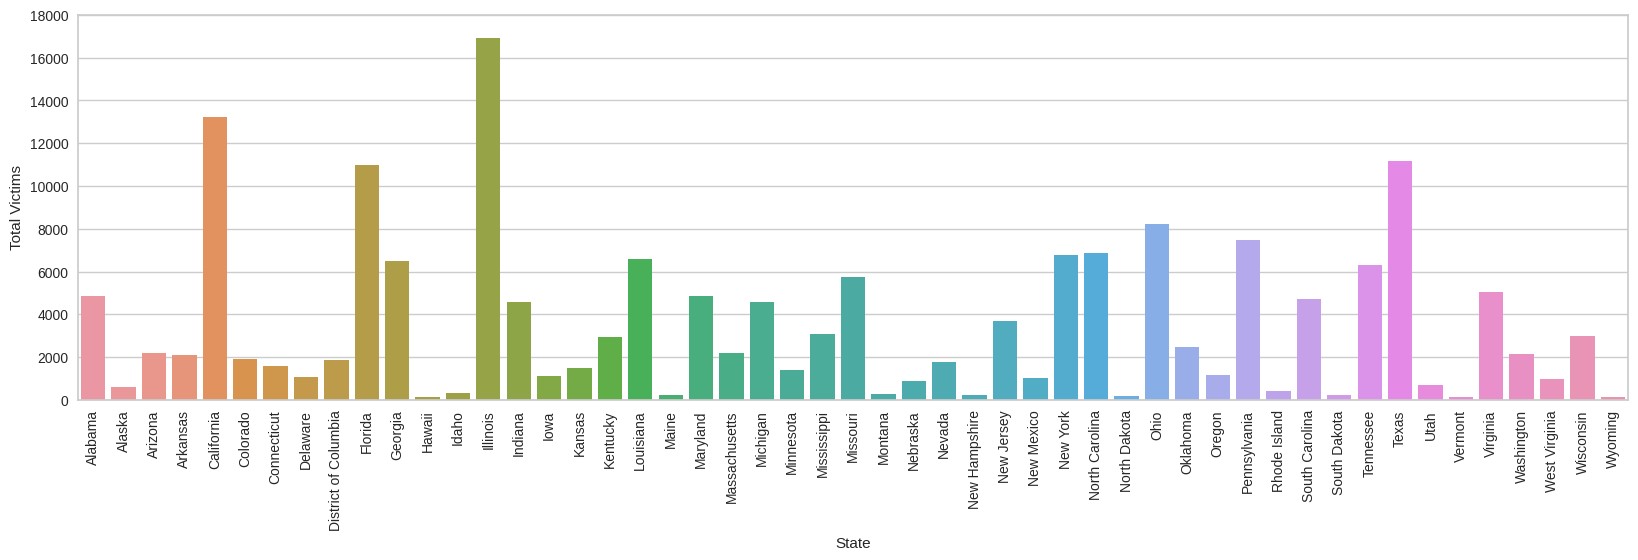

In [5]:
plt.figure(figsize=(20,5))
gvDf = gunviolence.sort_values(by=['state'])
states = (gvDf.groupby(['state']).sum()).index
sDF = (gvDf.groupby(['state']).sum())['victims']
combo = pd.DataFrame({'state':states,
                   'victims': sDF.values})


plt.xticks( rotation='vertical')
plt.ylim(ymax = 18000, ymin = 0)  
sns.barplot(x = 'state', y = 'victims', data=combo) 

plt.xlabel('State') 
plt.ylabel('Total Victims') 
#plt.title("Victim Count by State")
plt.show() 

In [34]:
#Feature Selection
subdata = gunviolence.filter(['date', 'state', 'city_or_county', 'n_killed', 'n_injured',
       'n_guns_involved', 'victims','n_victim'],axis=1)

#Encode Values
le = preprocessing.LabelEncoder()
le.fit(subdata["city_or_county"])
subdata["newcity"] = le.transform(subdata["city_or_county"]) 
le.fit(subdata["state"])
subdata["newstate"] = le.transform(subdata["state"])

subdata.fillna(0,inplace=True)

In [35]:
stringLessData = pd.DataFrame(subdata.drop(['state', 'city_or_county'],axis=1))
#Feature selection - picking the best feature
XBest = stringLessData.iloc[:,0:20]  
yBest = stringLessData.iloc[:,-1]

bestfeatures = SelectKBest(score_func=chi2, k=3)
fit = bestfeatures.fit(XBest,yBest)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(XBest.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
featureScores

,Specs,Score
0,date,1.766236e+05
1,victims,6.473462e+03
2,n_victim,6.473462e+03
3,newcity,1.019870e+08
4,newstate,2.117302e+06


In [8]:
stringLessData.describe().T

,count,mean,std,min,25%,50%,75%,max
date,239677.0,1533.018283,442.827461,366.0,1161.0,1556.0,1919.0,2281.0
victims,239677.0,0.746296,0.842343,0.0,0.0,1.0,1.0,103.0
n_victim,239677.0,0.746296,0.842343,0.0,0.0,1.0,1.0,103.0
newcity,239677.0,6148.656847,3732.303398,0.0,2435.0,6229.0,9279.0,12897.0
newstate,239677.0,23.557738,14.425999,0.0,10.0,22.0,36.0,50.0


<ipython-input-30-36aa77a65a6c>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(gunviolence.corr(), annot=True, cmap="coolwarm")


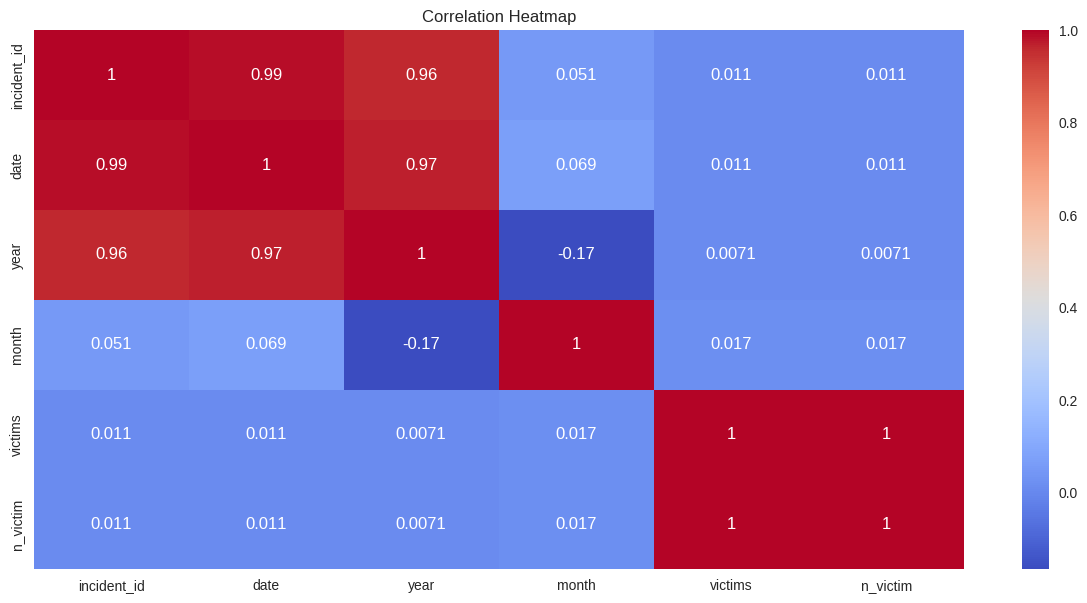

In [ ]:
#heatmap to visualize the correlation between the numerical columns
plt.figure(figsize=(15,7))
sns.heatmap(gunviolence.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

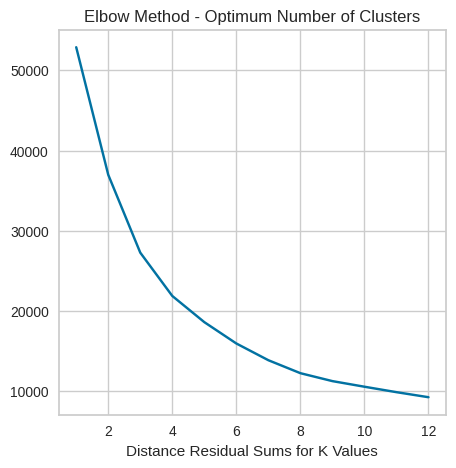

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

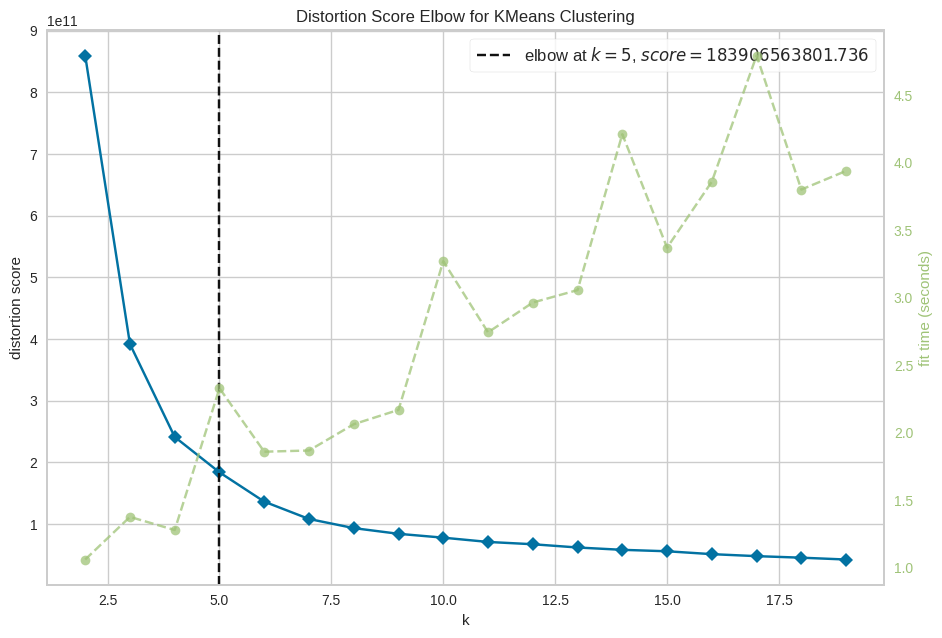

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# KMeans Clustering - Determine optimal number of clusters
kmeans = KMeans()
ssd = []
K_Range = range(1, 13)

for k in K_Range:
    kmeans = KMeans(n_clusters=k).fit(data_scaled)
    ssd.append(kmeans.inertia_)

ssd
plt.figure(figsize=(5,5))

plt.plot(K_Range, ssd, "bx-")
plt.xlabel("Distance Residual Sums for K Values")
plt.title("Elbow Method - Optimum Number of Clusters")
plt.show()

kmeans = KMeans()
elbow_Visual = KElbowVisualizer(kmeans, k=(2, 20), size=(1080, 720))
elbow_Visual.fit(stringLessData) 
elbow_Visual.show()

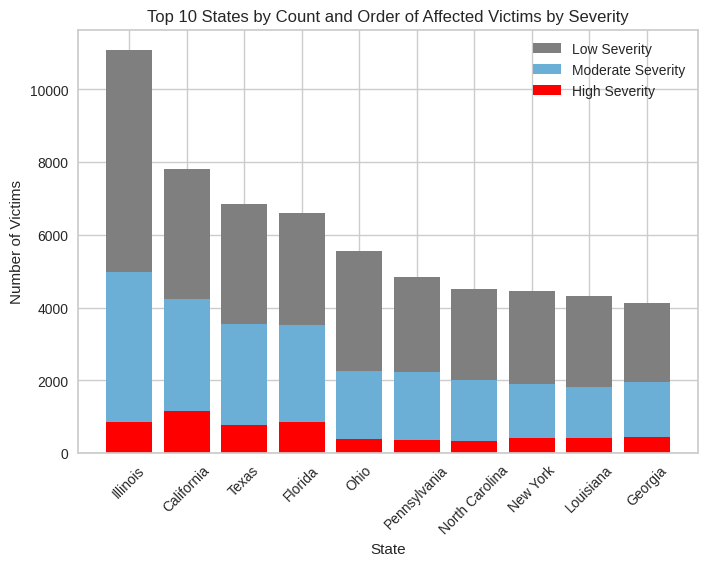

In [10]:
# Define the colors for the bar plot
colors = ['#7f7f7f', '#6baed6', 'red']

# Get the top 10 states by count
top_states = gunviolence['state'].value_counts().head(10).index.tolist()

# Get the order of affected victims by severity
order = ['Low Severity', 'Moderate Severity', 'High Severity']

# Create a bar plot for each severity level
for i, s in enumerate(order):
    # Get the data for the current severity level and top states
    data = gunviolence.loc[gunviolence['severity'] == s]
    data = data.loc[data['state'].isin(top_states)]
    
    # Get the total number of victims for each state
    agg = data.groupby(['state'])['n_victim'].sum().reset_index()
    
    # Sort the data by the number of victims
    agg = agg.sort_values(by=['n_victim'], ascending=False)
    
    # Create the bar plot with the color for the current severity level
    plt.bar(agg['state'], agg['n_victim'], color=colors[i], label=s)

# Set the title and axis labels
plt.title('Top 10 States by Count and Order of Affected Victims by Severity')
plt.xlabel('State')
plt.ylabel('Number of Victims')

# Rotate the x-axis tick labels to prevent overlapping
plt.xticks(rotation=45)

# Add the legend and show the plot
plt.legend()
plt.show()

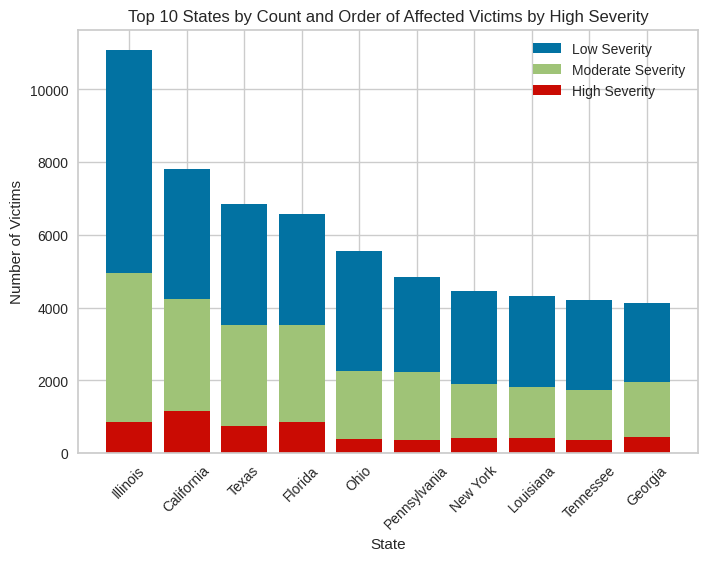

In [11]:
# Get the top 10 states by count
top_states = gunviolence.where(gunviolence['severity'] == 'High Severity')['state'].value_counts().head(10).index.tolist()
#gunviolence['state'].value_counts().tail(10).index.tolist()

# Get the order of affected victims by severity
order = ['Low Severity', 'Moderate Severity', 'High Severity']

# Create a bar plot for each severity level
for s in order:
    # Get the data for the current severity level and top states
    data = gunviolence.loc[gunviolence['severity'] == s]
    data = data.loc[data['state'].isin(top_states)]
    
    # Get the total number of victims for each state
    agg = data.groupby(['state'])['n_victim'].sum().reset_index()
    
    # Sort the data by the number of victims
    agg = agg.sort_values(by=['n_victim'], ascending=False)
    
    # Create the bar plot
    plt.bar(agg['state'], agg['n_victim'], label=s)

# Set the title and axis labels
plt.title('Top 10 States by Count and Order of Affected Victims by High Severity')
plt.xlabel('State')
plt.ylabel('Number of Victims')

# Rotate the x-axis tick labels to prevent overlapping
plt.xticks(rotation=45)

# Add the legend and show the plot
plt.legend()
plt.show()

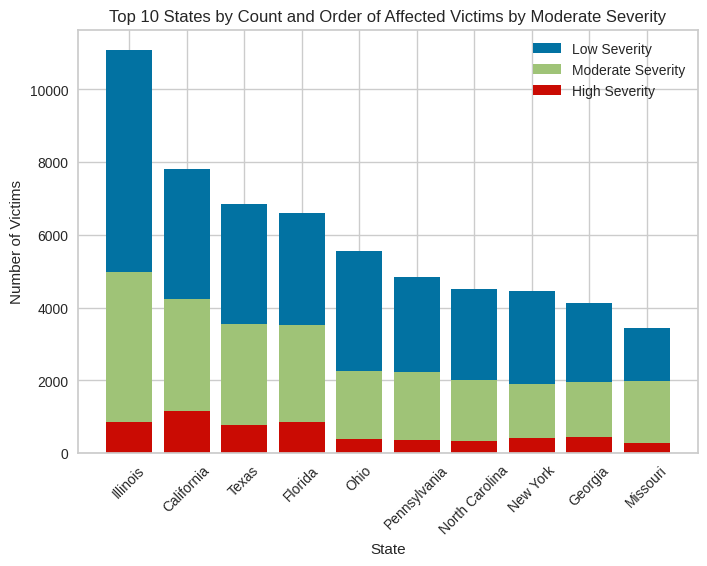

In [12]:
# Get the Top Mid 10 states by count
top_states = gunviolence.where(gunviolence['severity'] == 'Moderate Severity')['state'].value_counts().head(10).index.tolist()
#gunviolence['state'].value_counts().tail(10).index.tolist()

# Get the order of affected victims by severity
order = ['Low Severity', 'Moderate Severity', 'High Severity']

# Create a bar plot for each severity level
for s in order:
    # Get the data for the current severity level and top states
    data = gunviolence.loc[gunviolence['severity'] == s]
    data = data.loc[data['state'].isin(top_states)]
    
    # Get the total number of victims for each state
    agg = data.groupby(['state'])['n_victim'].sum().reset_index()
    
    # Sort the data by the number of victims
    agg = agg.sort_values(by=['n_victim'], ascending=False)
    
    # Create the bar plot
    plt.bar(agg['state'], agg['n_victim'], label=s)

# Set the title and axis labels
plt.title('Top 10 States by Count and Order of Affected Victims by Moderate Severity')
plt.xlabel('State')
plt.ylabel('Number of Victims')

# Rotate the x-axis tick labels to prevent overlapping
plt.xticks(rotation=45)

# Add the legend and show the plot
plt.legend()
plt.show()

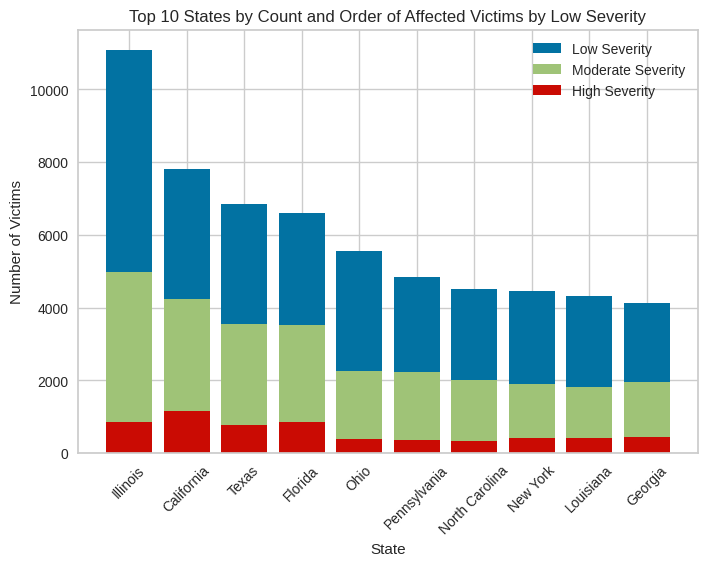

In [13]:
# Get the Top Low 10 states by count
top_states = gunviolence.where(gunviolence['severity'] == 'Low Severity')['state'].value_counts().head(10).index.tolist()
#gunviolence['state'].value_counts().tail(10).index.tolist()

# Get the order of affected victims by severity
order = ['Low Severity', 'Moderate Severity', 'High Severity']

# Create a bar plot for each severity level
for s in order:
    # Get the data for the current severity level and top states
    data = gunviolence.loc[gunviolence['severity'] == s]
    data = data.loc[data['state'].isin(top_states)]
    
    # Get the total number of victims for each state
    agg = data.groupby(['state'])['n_victim'].sum().reset_index()
    
    # Sort the data by the number of victims
    agg = agg.sort_values(by=['n_victim'], ascending=False)
    
    # Create the bar plot
    plt.bar(agg['state'], agg['n_victim'], label=s)

# Set the title and axis labels
plt.title('Top 10 States by Count and Order of Affected Victims by Low Severity')
plt.xlabel('State')
plt.ylabel('Number of Victims')

# Rotate the x-axis tick labels to prevent overlapping
plt.xticks(rotation=45)

# Add the legend and show the plot
plt.legend()
plt.show()

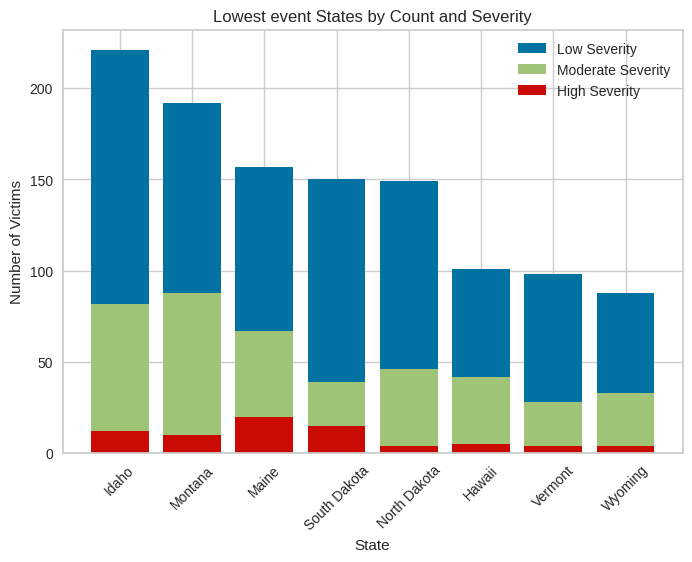

In [14]:
# Get the Top Low 10 states by count
Low_states = gunviolence.where(gunviolence['severity'] == 'Low Severity')['state'].value_counts().tail(10).index.tolist()
Moderate_states = gunviolence.where(gunviolence['severity'] == 'Moderate Severity')['state'].value_counts().tail(10).index.tolist()
top_states = gunviolence.where(gunviolence['severity'] == 'High Severity')['state'].value_counts().tail(10).index.tolist()

cross12 = [item for item in Low_states if item in Moderate_states] 
cross123 = [item for item in cross12 if item in top_states] 


#gunviolence['state'].value_counts().tail(10).index.tolist()

# Get the order of affected victims by severity
order = ['Low Severity', 'Moderate Severity', 'High Severity']

# Create a bar plot for each severity level
for s in order:
    # Get the data for the current severity level and top states
    data = gunviolence.loc[gunviolence['severity'] == s]
    data = data.loc[data['state'].isin(cross123)]
    
    # Get the total number of victims for each state
    agg = data.groupby(['state'])['n_victim'].sum().reset_index()
    
    # Sort the data by the number of victims
    agg = agg.sort_values(by=['n_victim'], ascending=False)
    
    # Create the bar plot
    plt.bar(agg['state'], agg['n_victim'], label=s)

# Set the title and axis labels
plt.title('Lowest event States by Count and Severity')
plt.xlabel('State')
plt.ylabel('Number of Victims')

# Rotate the x-axis tick labels to prevent overlapping
plt.xticks(rotation=45)

# Add the legend and show the plot
plt.legend()
plt.show()

<ipython-input-36-198772aedf9f>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sums = gunviolence.loc[gunviolence['state']==state].groupby(gunviolence.year, sort=False).sum().victims
<ipython-input-36-198772aedf9f>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sums = gunviolence.loc[gunviolence['state']==state].groupby(gunviolence.year, sort=False).sum().victims
<ipython-input-36-198772aedf9f>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be

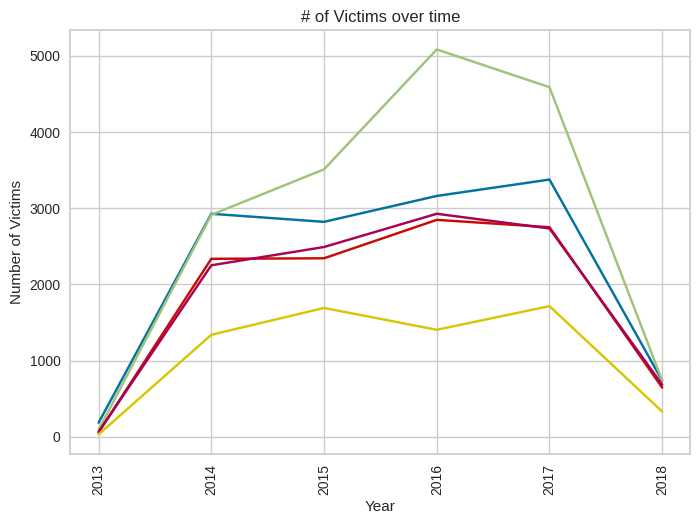

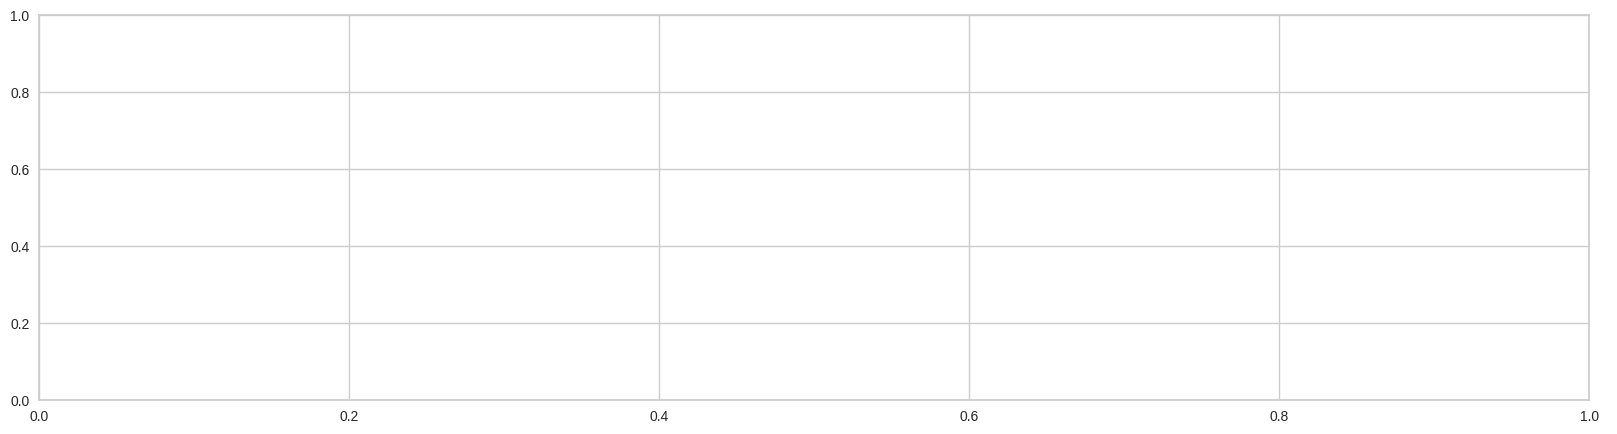

In [36]:
# Get the top 10 states by count
top_states = gunviolence.where(gunviolence['severity'] == 'High Severity')['state'].value_counts().head(5).index.tolist()
years = gunviolence.year.unique()

for state in top_states:
  sums = gunviolence.loc[gunviolence['state']==state].groupby(gunviolence.year, sort=False).sum().victims 
  plt.plot(years, sums)

#ax.set_xticklabels(dates, rotation=90) 

# Set the title and axis labels
plt.title('# of Victims over time')
plt.xlabel('Year')
plt.ylabel('Number of Victims')


plt.xticks(x=years, rotation=90)
plt.figure(figsize=(20,5))

# Add the legend and show the plot
plt.legend(top_states, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show();


<ipython-input-16-f2270e4d2c39>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sums = gunviolence.loc[gunviolence['state']==state].groupby(gunviolence.month, sort=False).sum().victims
<ipython-input-16-f2270e4d2c39>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sums = gunviolence.loc[gunviolence['state']==state].groupby(gunviolence.month, sort=False).sum().victims
<ipython-input-16-f2270e4d2c39>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou

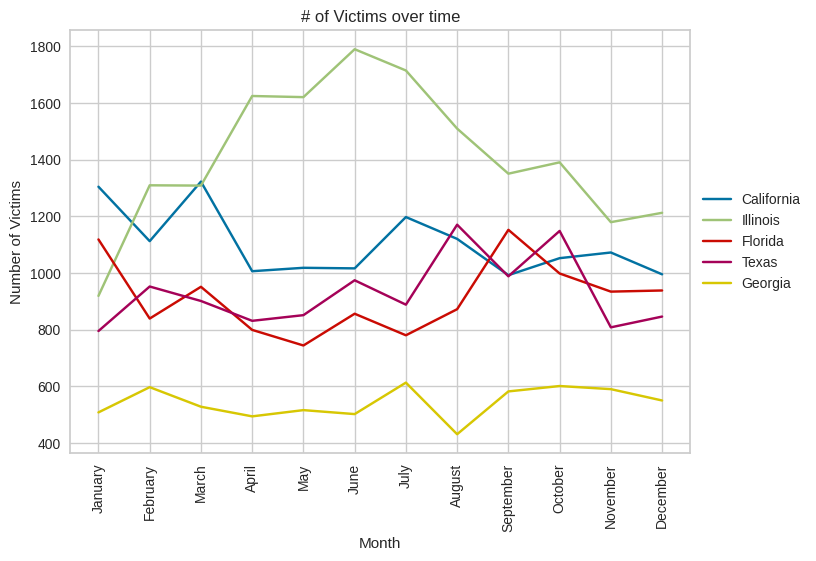

In [16]:
import calendar

# Get the top 10 states by count
top_states = gunviolence.where(gunviolence['severity'] == 'High Severity')['state'].value_counts().head(5).index.tolist()
months = gunviolence.month.unique()
monthName=[]
for x in range(1,13):
   monthName.append(calendar.month_name[x])

for state in top_states:
  sums = gunviolence.loc[gunviolence['state']==state].groupby(gunviolence.month, sort=False).sum().victims 
  plt.plot(months, sums)

x = np.asarray(months, dtype='int')
 
# Set the title and axis labels
plt.title('# of Victims over time')
plt.xlabel('Month')
plt.ylabel('Number of Victims')


plt.xticks(x=months,labels=monthName,ticks=months, rotation=90)

# Add the legend and show the plot
plt.legend(top_states, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show();


In [18]:
df.head()


,incident_id,date,state,city_or_county,newDate,year,month,victims,n_victim,severity
0,461105,366,38,7185,2013-01-01,2013,1,4,4,0
1,460726,366,4,4948,2013-01-01,2013,1,4,4,0
2,478855,366,35,6605,2013-01-01,2013,1,4,4,0
3,478925,370,5,450,2013-01-05,2013,1,4,4,0
4,478959,372,33,4613,2013-01-07,2013,1,4,4,0


In [19]:
# Encode the state and county columns
df = gunviolence

le = LabelEncoder()
df["state"] = le.fit_transform(df["state"])
df["city_or_county"] = le.fit_transform(df["city_or_county"])
df['severity'] = le.fit_transform(df['severity'])

X = df.drop('severity',axis=1)
Y = df['severity']

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(df[["date", "state", "city_or_county"]])
y = df["n_victim"]

In [20]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=3)

kmeans.fit(X)

clusters = kmeans.predict(X)
pca = PCA(n_components=2)
reduced_X = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2'])
reduced_X

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,PC1,PC2
0,2.107665,1.839520
1,0.190914,2.319107
2,1.881098,1.945724
3,-0.442252,3.059991
4,1.482465,2.273999
...,...,...
239672,-0.558776,-1.880253
239673,-0.814143,-1.596228
239674,-1.305661,-1.049550
239675,-0.043689,-1.238242


In [21]:
reduced_X['cluster'] = clusters
reduced_X
reduced_centers = pca.transform(kmeans.cluster_centers_)
reduced_centers

array([[-0.20285492, -0.44668635],
       [-0.74629979,  0.62342647],
       [ 1.06560259, -0.29136198]])

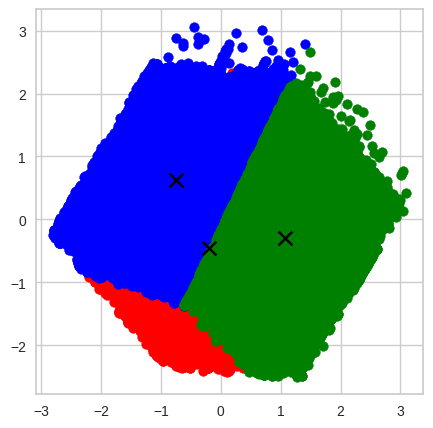

In [22]:
plt.figure(figsize=(5, 5))

plt.scatter(reduced_X[reduced_X['cluster'] == 0].loc[:, 'PC1'], reduced_X[reduced_X['cluster'] == 0].loc[:, 'PC2'], color='red')
plt.scatter(reduced_X[reduced_X['cluster'] == 1].loc[:, 'PC1'], reduced_X[reduced_X['cluster'] == 1].loc[:, 'PC2'], color='blue')
plt.scatter(reduced_X[reduced_X['cluster'] == 2].loc[:, 'PC1'], reduced_X[reduced_X['cluster'] == 2].loc[:, 'PC2'], color='green')


plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1], color='black', marker='x', s=100)

plt.show()

In [24]:
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPClassifier

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8)
model = MLPClassifier(hidden_layer_sizes=(256, 256), max_iter=500)

In [27]:
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Model Accuracy: 0.8935664218958611


# Logistic Regression for classification

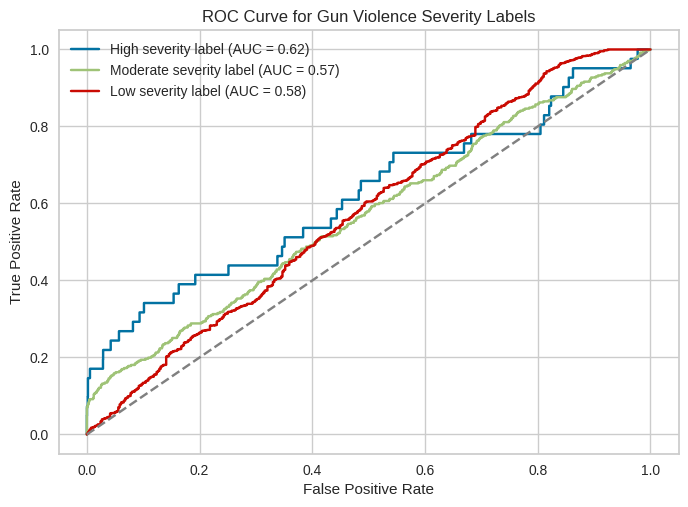

AUC for high severity label: 0.6185553255469918
AUC for moderate severity label: 0.5696215109810012
AUC for low severity label: 0.5768462771595017


In [30]:
from sklearn.model_selection import train_test_split

# Standardize the features
scaler = StandardScaler()
X_A = scaler.fit_transform(df[["date", "state", "city_or_county"]])
Y_B = df["n_victim"]

# Train a separate binary classifier for each label
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_A, Y_B, test_size=0.2, random_state=42)

# Create binary labels for each class
df['high_severity_label'] = df['n_victim'].apply(lambda x: 1 if x >= 7 else 0)
df['moderate_severity_label'] = df['n_victim'].apply(lambda x: 1 if 4 <= x < 7 else 0)
df['low_severity_label'] = df['n_victim'].apply(lambda x: 1 if x < 4 else 0)

X = df.drop(['n_victim', 'high_severity_label', 'moderate_severity_label', 'low_severity_label'], axis=1)
y_high = df['high_severity_label']
y_moderate = df['moderate_severity_label']
y_low = df['low_severity_label']

# Train a separate binary classifier for each label
model_high = LogisticRegression()
model_high.fit(X_train, df.loc[y_train.index, 'high_severity_label'])

model_moderate = LogisticRegression()
model_moderate.fit(X_train, df.loc[y_train.index, 'moderate_severity_label'])

model_low = LogisticRegression()
model_low.fit(X_train, df.loc[y_train.index, 'low_severity_label'])

# Get the predicted probabilities for each class
y_pred_proba_high = model_high.predict_proba(X_test)[:, 1]
y_pred_proba_moderate = model_moderate.predict_proba(X_test)[:, 1]
y_pred_proba_low = model_low.predict_proba(X_test)[:, 1]

# Combine the probabilities into a single array
y_pred_proba = np.vstack([y_pred_proba_high, y_pred_proba_moderate, y_pred_proba_low]).T

# Compute the ROC curve and AUC score for each class
fpr_high, tpr_high, thresholds_high = roc_curve(y_test.apply(lambda x: 1 if x >= 7 else 0), y_pred_proba_high)
auc_score_high = roc_auc_score(y_test.apply(lambda x: 1 if x >= 7 else 0), y_pred_proba_high)

fpr_moderate, tpr_moderate, thresholds_moderate = roc_curve(y_test.apply(lambda x: 1 if 4 <= x < 7 else 0), y_pred_proba_moderate)
auc_score_moderate = roc_auc_score(y_test.apply(lambda x: 1 if 4 <= x < 7 else 0), y_pred_proba_moderate)

fpr_low, tpr_low, thresholds_low = roc_curve(y_test.apply(lambda x: 1 if x < 4 else 0), y_pred_proba_low)
auc_score_low = roc_auc_score(y_test.apply(lambda x: 1 if x < 4 else 0), y_pred_proba_low)

# Plot the ROC curve for each class
plt.plot(fpr_high, tpr_high, label='High severity label (AUC = {:.2f})'.format(auc_score_high))
plt.plot(fpr_moderate, tpr_moderate, label='Moderate severity label (AUC = {:.2f})'.format(auc_score_moderate))
plt.plot(fpr_low, tpr_low, label='Low severity label (AUC = {:.2f})'.format(auc_score_low))

# Plot the random guessing line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Set the axis labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gun Violence Severity Labels')

# Show the legend
plt.legend()

# Show the plot
plt.show()

# Print the AUC scores for each class
print("AUC for high severity label:", auc_score_high)
print("AUC for moderate severity label:", auc_score_moderate)
print("AUC for low severity label:", auc_score_low)

Accuracy score for high severity label: 0.9991446929238985
Accuracy score for moderate severity label: 0.9922605140186916
Accuracy score for low severity label: 0.9914052069425902


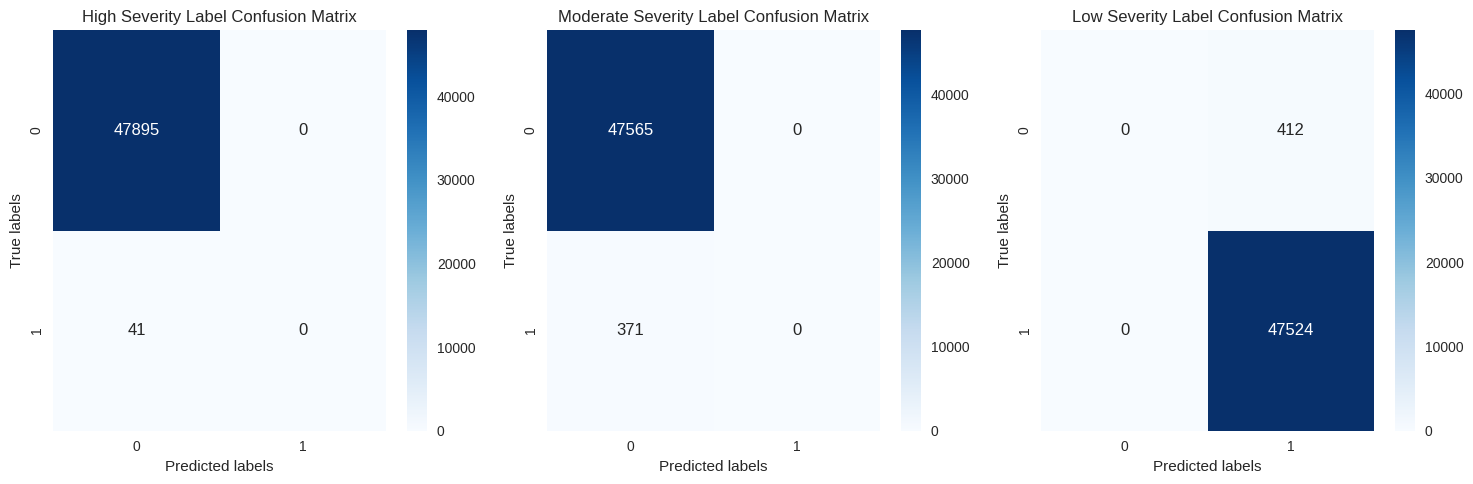

In [31]:
# Predict the labels for each class
y_pred_high = model_high.predict(X_test)
y_pred_moderate = model_moderate.predict(X_test)
y_pred_low = model_low.predict(X_test)

# Combine the predicted labels into a single array
y_pred = np.vstack([y_pred_high, y_pred_moderate, y_pred_low]).T

# Calculate the accuracy score for each class
acc_score_high = np.mean(y_test.apply(lambda x: 1 if x >= 7 else 0) == y_pred[:, 0])
acc_score_moderate = np.mean(y_test.apply(lambda x: 1 if 4 <= x < 7 else 0) == y_pred[:, 1])
acc_score_low = np.mean(y_test.apply(lambda x: 1 if x < 4 else 0) == y_pred[:, 2])

# Print the accuracy scores for each class
print("Accuracy score for high severity label:", acc_score_high)
print("Accuracy score for moderate severity label:", acc_score_moderate)
print("Accuracy score for low severity label:", acc_score_low)

# Calculate the confusion matrix for each class
cm_high = confusion_matrix(y_test.apply(lambda x: 1 if x >= 7 else 0), y_pred[:, 0])
cm_moderate = confusion_matrix(y_test.apply(lambda x: 1 if 4 <= x < 7 else 0), y_pred[:, 1])
cm_low = confusion_matrix(y_test.apply(lambda x: 1 if x < 4 else 0), y_pred[:, 2])

# Visualize the confusion matrices for each class
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.heatmap(cm_high, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('High Severity Label Confusion Matrix')

plt.subplot(1,3,2)
sns.heatmap(cm_moderate, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Moderate Severity Label Confusion Matrix')

plt.subplot(1,3,3)
sns.heatmap(cm_low, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Low Severity Label Confusion Matrix')

plt.tight_layout()
plt.show()

## **Other Types of models attempted - LSTM / RNN**

These produced low accuracy with the same data 47 & 48 %

In [ ]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(gunviolence[["date", "state", "city_or_county"]])
y = df["n_victim"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# LSTM
lstm = Sequential()
lstm.add(LSTM(units=64, activation="relu", input_shape=(X_train.shape[1], 1)))
lstm.add(Dense(units=1, activation="sigmoid"))
lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
lstm.fit(X_train.reshape(-1, X_train.shape[1], 1), y_train, epochs=10, batch_size=32)
lstm_pred = lstm.predict(X_test.reshape(-1, X_test.shape[1], 1))
lstm_pred = lstm_pred.round()
lstm_acc = accuracy_score(y_test, lstm_pred)
lstm_cm = confusion_matrix(y_test, lstm_pred)
lstm_cm

Epoch 1/10
5992/5992 [==============================] - 16s 2ms/step - loss: 0.5635 - accuracy: 0.4849
Epoch 2/10
5992/5992 [==============================] - 15s 2ms/step - loss: 0.5037 - accuracy: 0.4855
Epoch 3/10
5992/5992 [==============================] - 14s 2ms/step - loss: -38.5288 - accuracy: 0.4855
Epoch 4/10
5992/5992 [==============================] - 14s 2ms/step - loss: -662.4045 - accuracy: 0.4833
Epoch 5/10
5992/5992 [==============================] - 15s 2ms/step - loss: -2577.7639 - accuracy: 0.4775
Epoch 6/10
5992/5992 [==============================] - 16s 3ms/step - loss: -6693.3296 - accuracy: 0.4731
Epoch 7/10
5992/5992 [==============================] - 15s 2ms/step - loss: -13271.7080 - accuracy: 0.4719
Epoch 8/10
5992/5992 [==============================] - 15s 2ms/step - loss: -18003.3320 - accuracy: 0.4731
Epoch 9/10
5992/5992 [==============================] - 15s 2ms/step - loss: -31573.5977 - accuracy: 0.4719
Epoch 10/10
1498/1498 [======================

array([[ 2606, 16816,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [ 2882, 20370,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [  511,  3482,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   86,   771,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   30,   231,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   12,    70,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [    2,    26,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [    1,    17,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [    0,    11,   

In [ ]:
#RNN
from tensorflow.keras.layers import SimpleRNNCell
X_train = X_train.astype(float)
rnn = Sequential()
rnn.add(RNN(cell=SimpleRNNCell(units=64, activation="relu"), input_shape=(X_train.shape[1], 1)))
rnn.add(Dense(units=1, activation="sigmoid"))
rnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
rnn.fit(X_train.reshape(-1, X_train.shape[1], 1), y_train, epochs=10, batch_size=32)
rnn_pred = rnn.predict(X_test.reshape(-1, X_test.shape[1], 1))
rnn_pred = rnn_pred.round()
rnn_acc = accuracy_score(y_test, rnn_pred)
rnn_cm = confusion_matrix(y_test, rnn_pred)
rnn_cm

Epoch 1/10
5992/5992 [==============================] - 11s 2ms/step - loss: 0.5607 - accuracy: 0.4849
Epoch 2/10
5992/5992 [==============================] - 10s 2ms/step - loss: 0.5392 - accuracy: 0.4854
Epoch 3/10
5992/5992 [==============================] - 11s 2ms/step - loss: -0.7405 - accuracy: 0.4866
Epoch 4/10
5992/5992 [==============================] - 11s 2ms/step - loss: -17.2000 - accuracy: 0.4868
Epoch 5/10
5992/5992 [==============================] - 10s 2ms/step - loss: -94.8347 - accuracy: 0.4866
Epoch 6/10
5992/5992 [==============================] - 11s 2ms/step - loss: -335.2756 - accuracy: 0.4794
Epoch 7/10
5992/5992 [==============================] - 10s 2ms/step - loss: -814.4854 - accuracy: 0.4767
Epoch 8/10
5992/5992 [==============================] - 10s 2ms/step - loss: -1662.1604 - accuracy: 0.4746
Epoch 9/10
5992/5992 [==============================] - 10s 2ms/step - loss: -2989.8254 - accuracy: 0.4709
Epoch 10/10
1498/1498 [==============================]

array([[ 1615, 17807,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [ 1791, 21461,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [  314,  3679,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   72,   785,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   17,   244,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [    3,    79,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [    3,    25,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [    2,    16,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [    0,    11,   

In [ ]:
#Calculate Accuracy
print('LSTM Accuracy:', lstm_acc)
print('RNN Accuracy:', rnn_acc)

LSTM Accuracy: 0.47930574098798395
RNN Accuracy: 0.4813918558077437
